# Custom CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

## Not Augmented

In [ ]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(validation_split=0.15,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
download_dir = Path('drive/MyDrive/all')

In [ ]:
train_data_dir = download_dir/'z/train'
test_data_dir = download_dir/'z/test'

class_subset = sorted(os.listdir(download_dir))[:15]

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 765 images belonging to 15 classes.
Found 134 images belonging to 15 classes.
Found 225 images belonging to 15 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    x = Input(shape=input_shape)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(.5)(h)
    output_layer = Dense(n_classes, activation='softmax')(h)
    
    model = Model(inputs=x, outputs=output_layer)

    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim = Adam(learning_rate=0.001)
n_classes=15

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
custom_model_ft = create_model(input_shape, n_classes, optim, fine_tune=2)

In [ ]:
n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='custom_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

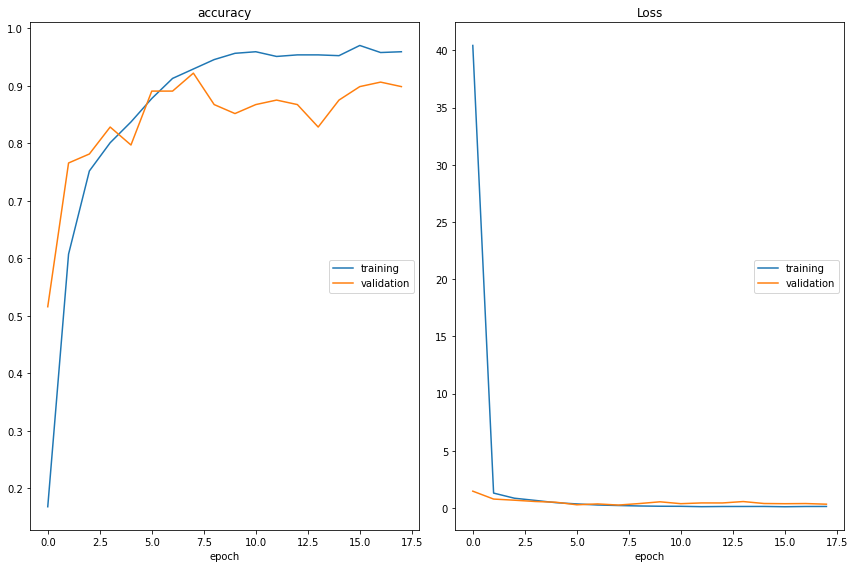

accuracy
	training         	 (min:    0.168, max:    0.970, cur:    0.959)
	validation       	 (min:    0.516, max:    0.922, cur:    0.898)
Loss
	training         	 (min:    0.117, max:   40.432, cur:    0.141)
	validation       	 (min:    0.264, max:    1.478, cur:    0.339)
23/23 [==============================] - 154s 7s/step - loss: 0.1412 - accuracy: 0.9591 - val_loss: 0.3393 - val_accuracy: 0.8984


In [ ]:
plot_loss_1 = PlotLossesCallback()

# Retrain model with fine-tuning
custom_ft_history = custom_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                                  verbose=1)
custom_model_ft.save('drive/MyDrive/model/custom_model.h5')

In [ ]:
custom_model_ft.load_weights('custom_model_v1.weights.best.hdf5') # initialize the best trained weights

custom_preds_ft = custom_model_ft.predict(testgen)
custom_pred_classes_ft = np.argmax(custom_preds_ft, axis=1)

225/225 [==============================] - 50s 224ms/step


In [ ]:
true_classes = testgen.classes

In [ ]:
from sklearn.metrics import accuracy_score
custom_acc_ft = accuracy_score(true_classes, custom_pred_classes_ft)
print("Custom Model Accuracy with Fine-Tuning: {:.2f}%".format(custom_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 88.89%


In [ ]:
from sklearn.metrics import accuracy_score
custom_acc_ft = accuracy_score(true_classes, custom_pred_classes_ft)
print("Custom Model Accuracy: {:.2f}%".format(custom_acc_ft * 100))

Custom Model Accuracy: 88.98%


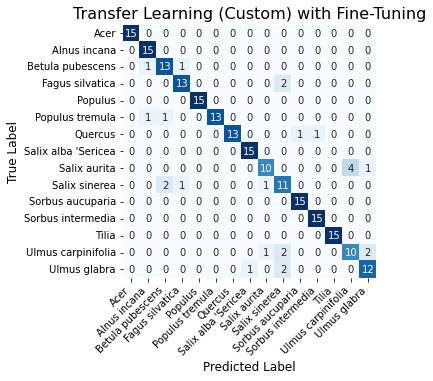

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax1 = plt.subplots(1, 1)
 
plot_heatmap(true_classes, custom_pred_classes_ft, class_names, ax1, title="Transfer Learning (Custom) with Fine-Tuning")    

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

## Augmented

In [ ]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
download_dir = Path('drive/MyDrive/all')

In [ ]:
train_data_dir = download_dir/'z/train'
test_data_dir = download_dir/'z/test'

class_subset = sorted(os.listdir(download_dir))[:15]

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 765 images belonging to 15 classes.
Found 134 images belonging to 15 classes.
Found 225 images belonging to 15 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    x = Input(shape=input_shape)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(.5)(h)
    output_layer = Dense(n_classes, activation='softmax')(h)
    
    model = Model(inputs=x, outputs=output_layer)

    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim = Adam(learning_rate=1e-06)
n_classes=15

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
custom_aug_model_ft = create_model(input_shape, n_classes, optim, fine_tune=2)

In [ ]:
n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100

# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = ModelCheckpoint(filepath='custom_aug_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

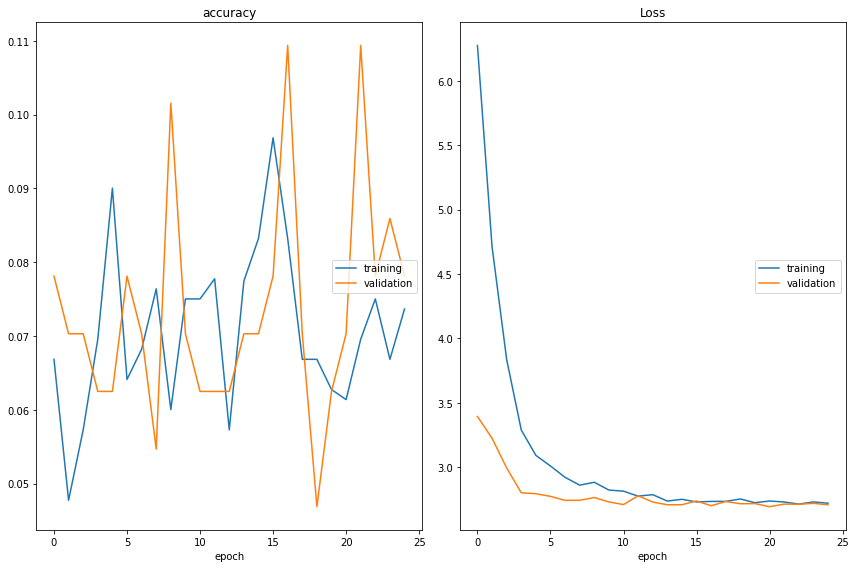

accuracy
	training         	 (min:    0.048, max:    0.097, cur:    0.074)
	validation       	 (min:    0.047, max:    0.109, cur:    0.078)
Loss
	training         	 (min:    2.713, max:    6.275, cur:    2.720)
	validation       	 (min:    2.693, max:    3.394, cur:    2.707)
23/23 [==============================] - 273s 12s/step - loss: 2.7199 - accuracy: 0.0737 - val_loss: 2.7075 - val_accuracy: 0.0781
Epoch 26/100
22/23 [===========================>..] - ETA: 9s - loss: 2.7084 - accuracy: 0.0785 

In [ ]:
plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
custom_aug_ft_history = custom_aug_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_2, early_stop, plot_loss_2],
                                  verbose=1)
custom_aug_model_ft.save('drive/MyDrive/model/custom_aug_model_aug.h5')

In [ ]:
custom_aug_model_ft.load_weights('custom_aug_model_v1.weights.best.hdf5') # initialize the best trained weights

custom_aug_preds_ft = custom_aug_model_ft.predict(testgen)
custom_aug_pred_classes_ft = np.argmax(custom_aug_preds_ft, axis=1)

In [ ]:
true_classes = testgen.classes

In [ ]:
from sklearn.metrics import accuracy_score
custom_aug_acc_ft = accuracy_score(true_classes, custom_aug_pred_classes_ft)
print("Custom Model Accuracy with Fine-Tuning: {:.2f}%".format(custom_aug_acc_ft * 100))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax1 = plt.subplots(1, 1)
 
plot_heatmap(true_classes, custom_aug_pred_classes_ft, class_names, ax1, title="Custom model with data augmentation")    

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()